# Experiments with Pseudo-labeling

Last week I read an article titled "[Simple explanation of Semi-Supervised Learning and Pseudo Labeling](https://towardsdatascience.com/simple-explanation-of-semi-supervised-learning-and-pseudo-labeling-c2218e8c769b)" on Towards Data Science, and it's this article that's motivated me to create this notebook.

Now, most machine learning algorithms fall under the category of Supervised Learning, where you have examples of the thing you are trying to predict. Unfortunately, there are times when you don't have many examples, and in this instance, Pseudo-labeling *might* help. 

I'll explain how pseudo-labeling works as I go along. Now, let's import the libraries we'll need for this experiment.

In [1]:
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import matplotlib.pyplot as plt

The make_classification function generates a dataset for classification.

Useful parameters include:

* n_samples: the number of samples to create.
* n_features: the total number of predictors in the dataset = n_informative + n_redundant + n_repeated.
* n_informative: the number of informative predictors to create.
* n_redundant: the number of redundant predictors to create. These are random linear combinations of the informative predictors.
* n_repeated: the number of duplicated predictors, drawn from n_redundant and n_repeated.
* n_classes: the number of classes, where the default is 2.
* weights: the proprtion of samples assigned to each class, where the default is 0.5.
* random_state: seeds the random number generators, where the default is None.

I'm going to create 10,000 records, with 3 informative predictors and 2 redundant predictors. For reproducibility, I'm going to seed the random number generator.

In [2]:
X, y = make_classification(n_samples = 10000, n_features = 5,
                           n_informative = 3, n_redundant = 2,
                          random_state = 34)

With this experiment, I'm going to let the model use 1,000 real examples. The other 9,000 examples will be known to me, but not the model.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.9, random_state = 34)

print("Number of known labels:{0:5d}".format(len(X_train)))
print("Number of unknown labels:{0:5d}".format(len(X_test)))

Number of known labels: 1000
Number of unknown labels: 9000


## No Pseudo-labeling

Before explaining the pseudo-labeling, I'm going to build a nearest neighbors classifier, using the 1,000 known examples, then measure the accuracy on the 9,000 examples with unknown labels.

In [4]:
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
yhat = clf.predict(X_test)
score_1 = accuracy_score(y_test, yhat)
scores = [score_1]
print("Model Accuracy: {0:0.3f}".format(score_1))

Model Accuracy: 0.916


This will be used for comparison purposes, now onwards to pseudo-labeling.

## Pseudo-labeling 2,000 Records

With Pseudo-labeling, I will create new labels, by building a model with the small set of known labels available, then predicting the label on a subset of the samples with unknown labels.

To do this, I'll start by splitting the unknown labels into 2 sets.

In [5]:
X_unlabeled, X_test_new, y_unlabeled, y_test_new = train_test_split(X_test, y_test, test_size = 7000, random_state = 34)

Next, I'll fit the model to the samples with known labels, and predict the label for 2,000 records with unknown labels.

In [6]:
clf.fit(X_train, y_train)
yhat = clf.predict(X_unlabeled)

Of the predicted class labels, I will assume that the class labels with the maximum predicted probability are as good as the known labels. These labels are called *pseudo labels*.

In [7]:
y_probs = clf.predict_proba(X_unlabeled)
mask = np.logical_or(y_probs[:,0] == np.max(y_probs[:,0]), 
                                     y_probs[:,1] == np.max(y_probs[:,1]))
y_pseudo = yhat[mask]
X_pseduo = X_unlabeled[mask,:]

Next, I'm going to add the records with pseudo labels to the set of records with known labels, then use the remaining records for the test set.

In [8]:
y_train_new = np.concatenate([y_train, y_pseudo])
X_train_new = np.concatenate([X_train, X_pseduo])

X_test_new = np.concatenate([X_unlabeled[~mask,:], X_test_new])
y_test_new = np.concatenate([yhat[~mask], y_test_new])

print("Number of records with known or psuedo labels:{0:5d}".format(len(y_train_new)))
print("Number of records with unknown labels, used for validation:{0:5d}".format(len(y_test_new)))

Number of records with known or psuedo labels: 2487
Number of records with unknown labels, used for validation: 7513


Now, I'll fit the model to the new dataset with known and *pseduo* labels, predict the outcomes for the remaining records, then measure the accuracy of the model.

In [9]:
clf.fit(X_train_new, y_train_new)

yhat_new = clf.predict(X_test_new)
score_2 = accuracy_score(y_test_new, yhat_new)
scores.append(score_2)
print("Model Accuracy: {0:0.3f}".format(score_2))

Model Accuracy: 0.923


That's it. To recap, pseudo-labeling works by:

1. Fitting a model to a dataset with known labels.
2. Predicting the label for some records with an unknown labels.
3. Treating predicted labels with maximum predicted probability as known labels, i.e. *pseduo* labels.
4. Fitting a model to the records with known labels or pseudo labels.

## Pseudo-labeling 4,000 Records

Ok, I created pseudo labels using 2,000 records. Maybe I could boost performance if I created pseudo labels for even more records. Let's test that.

In [10]:
X_unlabeled, X_test_new, y_unlabeled, y_test_new = train_test_split(X_test, y_test, test_size = 5000, random_state = 34)

clf.fit(X_train, y_train)
yhat = clf.predict(X_unlabeled)

y_probs = clf.predict_proba(X_unlabeled)
mask = np.logical_or(y_probs[:,0] == np.max(y_probs[:,0]), 
                                     y_probs[:,1] == np.max(y_probs[:,1]))
y_pseudo = yhat[mask]
X_pseduo = X_unlabeled[mask,:]

y_train_new = np.concatenate([y_train, y_pseudo])
X_train_new = np.concatenate([X_train, X_pseduo])

X_test_new = np.concatenate([X_unlabeled[~mask,:], X_test_new])
y_test_new = np.concatenate([yhat[~mask], y_test_new])

print("Number of records with known or psuedo labels:{0:5d}".format(len(y_train_new)))
print("Number of records with unknown labels, used for validation:{0:5d}".format(len(y_test_new)))

Number of records with known or psuedo labels: 3965
Number of records with unknown labels, used for validation: 6035


Let's measure model performance.

In [11]:
clf.fit(X_train_new, y_train_new)

yhat_new = clf.predict(X_test_new)
score_3 = accuracy_score(y_test_new, yhat_new)
scores.append(score_3)
print("Model Accuracy: {0:0.3f}".format(score_3))

Model Accuracy: 0.922


## Pseudo-labeling 7,000 Records

For the sake of comparison, let's create even more pseudo labels.

In [12]:
X_unlabeled, X_test_new, y_unlabeled, y_test_new = train_test_split(X_test, y_test, test_size = 2000, random_state = 34)

clf.fit(X_train, y_train)
yhat = clf.predict(X_unlabeled)

y_probs = clf.predict_proba(X_unlabeled)
mask = np.logical_or(y_probs[:,0] == np.max(y_probs[:,0]), 
                                     y_probs[:,1] == np.max(y_probs[:,1]))
y_pseudo = yhat[mask]
X_pseduo = X_unlabeled[mask,:]

y_train_new = np.concatenate([y_train, y_pseudo])
X_train_new = np.concatenate([X_train, X_pseduo])

X_test_new = np.concatenate([X_unlabeled[~mask,:], X_test_new])
y_test_new = np.concatenate([yhat[~mask], y_test_new])

print("Number of records with known or psuedo labels:{0:5d}".format(len(y_train_new)))
print("Number of records with unknown labels, used for validation:{0:5d}".format(len(y_test_new)))

Number of records with known or psuedo labels: 6194
Number of records with unknown labels, used for validation: 3806


Measuring model performance...

In [13]:
clf.fit(X_train_new, y_train_new)

yhat_new = clf.predict(X_test_new)
score_4 = accuracy_score(y_test_new, yhat_new)
scores.append(score_4)
print("Model Accuracy: {0:0.3f}".format(score_4))

Model Accuracy: 0.921


## Pseudo-labeling 8,000 Records

Alright, the more records the merrier, right? Creating even more pseudo labels...

In [14]:
X_unlabeled, X_test_new, y_unlabeled, y_test_new = train_test_split(X_test, y_test, test_size = 1000, random_state = 34)

clf.fit(X_train, y_train)
yhat = clf.predict(X_unlabeled)

y_probs = clf.predict_proba(X_unlabeled)
mask = np.logical_or(y_probs[:,0] == np.max(y_probs[:,0]), 
                                     y_probs[:,1] == np.max(y_probs[:,1]))
y_pseudo = yhat[mask]
X_pseduo = X_unlabeled[mask,:]

y_train_new = np.concatenate([y_train, y_pseudo])
X_train_new = np.concatenate([X_train, X_pseduo])

X_test_new = np.concatenate([X_unlabeled[~mask,:], X_test_new])
y_test_new = np.concatenate([yhat[~mask], y_test_new])

print("Number of records with known or psuedo labels:{0:5d}".format(len(y_train_new)))
print("Number of records with unknown labels, used for validation:{0:5d}".format(len(y_test_new)))

Number of records with known or psuedo labels: 6946
Number of records with unknown labels, used for validation: 3054


And measuring model performance...

In [15]:
clf.fit(X_train_new, y_train_new)

yhat_new = clf.predict(X_test_new)
score_5 = accuracy_score(y_test_new, yhat_new)
scores.append(score_5)
print("Model Accuracy: {0:0.3f}".format(score_5))

Model Accuracy: 0.918


## Results

Did the method work? Let's see.

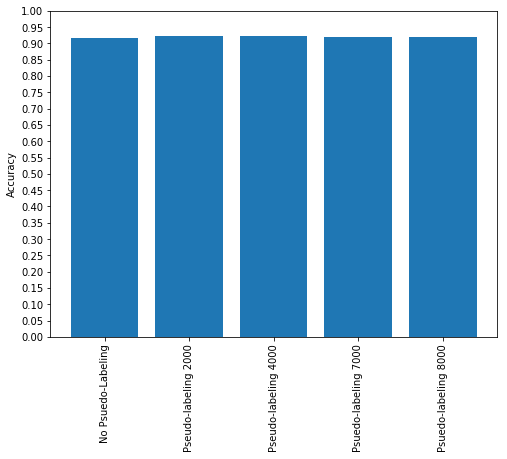

In [16]:
bar_position = np.arange(5)
plt.figure(figsize=(8,6))
plt.bar(bar_position, scores)
plt.ylabel("Accuracy")
plt.yticks(np.arange(0, 1.05, step = 0.05))
plt.xticks(bar_position, ('No Psuedo-Labeling',
                          'Pseudo-labeling 2000',
                          'Pseudo-labeling 4000',
                          'Psuedo-labeling 7000',
                          'Psuedo-labeling 8000'),
          rotation = 'vertical')
plt.show()

## Discussion

Pseudo-labeling didn't really make that much of a difference on this dataset. The highest accuracy achieved was only 0.7% higher than the model with no pseudo-labeling. 

Then again, I only tested a KNearestNeighbors algorithm, while the author referenced in the Towards Data Science article used a Deep Neural Network.

I'm not sure if I'd use this at work, though this kind of trick may get me a little higher on a Kaggle competition leaderboard.

As always, thanks for reading!